In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
os.environ['KERAS_BACKEND']='tensorflow'
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers.merge import concatenate
from keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
embed_file1 = os.path.join('.', 'Glove', 'glove.6B.200d.txt')
embed_file2 = os.path.join('.', 'fasttext', 'wiki-news-300d-1M.vec')
train_file = os.path.join('.', 'train.csv')
test_file = os.path.join('.', 'test.csv')

In [3]:
embed_size1 = 200 # how big is each word vector
embed_size2 = 300 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [4]:
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

In [5]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [6]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index1 = dict(get_coefs(*o.strip().split()) for o in open(embed_file1, encoding='utf-8'))
embeddings_index2 = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(embed_file2, encoding = 'utf-8'))

In [7]:
all_embs1 = np.hstack(embeddings_index1.values())
emb_mean1,emb_std1 = all_embs1.mean(), all_embs1.std()
emb_mean1,emb_std1

(-0.008671864, 0.38186216)

In [8]:
all_embs2 = np.hstack(embeddings_index2.values())
emb_mean2,emb_std2 = all_embs2.mean(), all_embs2.std()
emb_mean2,emb_std2

(-0.0033459952, 0.1112124)

In [9]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix1 = np.random.normal(emb_mean1, emb_std1, (nb_words, embed_size1))
embedding_matrix2 = np.random.normal(emb_mean2, emb_std2, (nb_words, embed_size2))

for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector1 = embeddings_index1.get(word)
    if embedding_vector1 is not None: embedding_matrix1[i] = embedding_vector1
        
for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector2 = embeddings_index2.get(word)
    if embedding_vector2 is not None: embedding_matrix2[i] = embedding_vector2

In [10]:
from keras import backend as K
K.clear_session()

In [11]:
inp = Input(shape=(maxlen,))
x1 = Embedding(max_features, embed_size1, weights=[embedding_matrix1], trainable = False)(inp)
x2 = Embedding(max_features, embed_size2, weights=[embedding_matrix2], trainable = False)(inp)
x = concatenate([x1,x2])
x = SpatialDropout1D(0.4)(x)

x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x, h, _ = Bidirectional(GRU(64, return_sequences=True, return_state=True, dropout=0.1, recurrent_dropout=0.1))(x)
gmp = GlobalMaxPooling1D()(x)
gap = GlobalAveragePooling1D()(x)
conc = concatenate([h, gmp, gap])
x = Dense(64, activation="relu")(conc)
x = Dropout(0.3)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
adam = optimizers.Adam(clipnorm=6.0)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=()):
        super(Callback, self).__init__()
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.X_val, verbose=0)
        score = roc_auc_score(self.y_val, y_pred)
        print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

X_tra, X_val, y_tra, y_val = train_test_split(X_t, y, train_size=0.95, random_state=8)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [13]:
cp = ModelCheckpoint(filepath="my_model10.h5", save_best_only=True)
es = EarlyStopping(patience=1)
rp = ReduceLROnPlateau(patience = 0)
hist = model.fit(X_tra, y_tra, batch_size = 64, epochs=10, validation_data=(X_val, y_val), callbacks=[cp, es, rp, RocAuc])

Train on 151592 samples, validate on 7979 samples
Epoch 1/10
151592/151592 [==============================] - 2513s 17ms/step - loss: 0.0631 - acc: 0.9787 - val_loss: 0.0473 - val_acc: 0.9829

 ROC-AUC - epoch: 1 - score: 0.978672 

Epoch 2/10
151592/151592 [==============================] - 2623s 17ms/step - loss: 0.0505 - acc: 0.9816 - val_loss: 0.0439 - val_acc: 0.9833

 ROC-AUC - epoch: 2 - score: 0.983510 

Epoch 3/10
151592/151592 [==============================] - 2605s 17ms/step - loss: 0.0473 - acc: 0.9825 - val_loss: 0.0419 - val_acc: 0.9838

 ROC-AUC - epoch: 3 - score: 0.986052 

Epoch 4/10
151592/151592 [==============================] - 2515s 17ms/step - loss: 0.0453 - acc: 0.9830 - val_loss: 0.0414 - val_acc: 0.9845

 ROC-AUC - epoch: 4 - score: 0.987478 

Epoch 5/10
151592/151592 [==============================] - 2648s 17ms/step - loss: 0.0438 - acc: 0.9835 - val_loss: 0.0408 - val_acc: 0.9839

 ROC-AUC - epoch: 5 - score: 0.986577 

Epoch 6/10
151592/151592 [=========

{'val_loss': [0.04725263059337212, 0.043892516594308706, 0.04193341837074691, 0.041413443243575286, 0.04079706032542989, 0.04239397850165407], 'val_acc': [0.9829343605316407, 0.9833312353509338, 0.9837698863329244, 0.9845218621918037, 0.9838952248833625, 0.9842503125513089], 'loss': [0.06313926813189864, 0.05047885447628889, 0.04730905911506411, 0.04531646312137123, 0.04383396750174573, 0.042764303470016175], 'acc': [0.9787400770806418, 0.9816239143469773, 0.9825111649440168, 0.9830366972694485, 0.983473174782364, 0.9837810191650669], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}


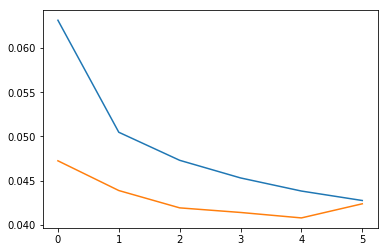

In [14]:
print (hist.history)
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot (hist.history['loss'])
plt.plot (hist.history['val_loss'])
#plt.plot (hist.history['RocAus'])

In [15]:
y_pred = model.predict(X_te, batch_size=256)
submission = pd.read_csv('./sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission10.csv', index=False)